# Machine Learning LAB 3: CLUSTERING - K-means and linkage-based clustering

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks about **CLUSTERING**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Image segmentation with k-means

In this laboratory we will use the k-means algorithm to cluster a dataset of 3D points. We will apply **K-means** to the problem of image compression and image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color with the closest representative color. This will allow us to reduce the number of colors in the image and compress it. A color is a vector of 3 values (R,G,B) that represent the amount of red, green and blue in the color; this implies that each pixel is a point in a 3D space.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In the second part of the laboratory we will use a **linkage-based** clustering algorithm to cluster a dataset of 2D points and compare it with the results obtained with k-means.

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB03.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Giacomo Longaroni

**ID Number**: 2126898

---

## Import all the necessary Python libraries

In [2]:
%matplotlib inline  

import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `img_plot` -> function to plot an image with name and dimension as title,
2. `scatter_plot` -> function to plot a scatter plot of the data,
3. `scatter_plot_2d` -> function to plot a 2D scatter plot of the data,
4. `error_plot` -> function to plot the error of the k-means algorithm over the iterations,
5. `cluster_plot` -> function to plot the obtained clusters.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [3]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    """
    Plot an image
    :param img: image to plot
    :param title: title of the plot
    """
    
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param data: data to plot
    :param clusters: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1)
    if title is not None:
        plt.title(title)
    if clusters is None:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=data, s=5)
    else:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [5]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param x: data to plot
    :param y: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """

    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [7]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    """
    Plot the clusters
    :param labels: cluster labels
    :param x: data
    :param title: title of the plot
    """
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

---

## A) K-means clustering

### TO DO (A.0)
    
**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [8]:

ID = 2126898  
np.random.seed(ID)

Load the provided images and display them (if you like you can experiment with other images)

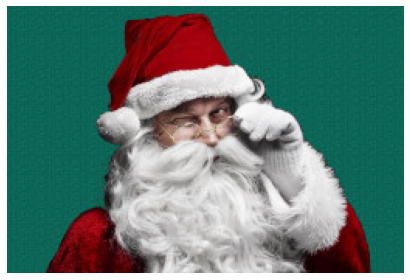

(172, 256, 3)


In [9]:
# To load the images use the function plt.imread(<path_to_iamge>)
# ADD YOUR CODE HERE
im = (plt.imread('/Users/giacomo/Desktop/POD/ML_POD/lab3-2/data/santaclaus2.jpg'))
# Plot the images with their shapes
# Sugestion: use the function img_plot()

img_plot(im)
print(im.shape)

We are going to start by using the Santa Claus image.


In [10]:
# Reshape the data to a matrix of num_pixels x 3 
# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)
# ADD YOUR CODE HERE
im = im/255
print('image shape', im.shape)
im = im.reshape(im.shape[0]*im.shape[1],3) #172x256
print('new shape: ', im.shape)
# Print the shape of the data and the min and max values of the pixels
# ADD YOUR CODE HERE
print('\nmean image as a normalized vector:', im.mean())
print('max image as a normalized vector: ', im.max())
print('min image as a normalized vector: ', im.min())

image shape (172, 256, 3)
new shape:  (44032, 3)

mean image as a normalized vector: 0.411898803247074
max image as a normalized vector:  1.0
min image as a normalized vector:  0.0


Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

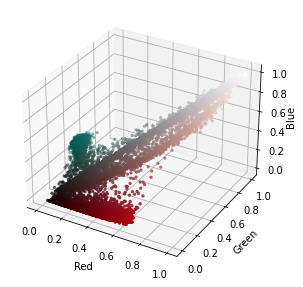

In [11]:

scatter_plot(im)





### TO DO (A.1)
Implement the k-means algorithm manually (**do not use the kmeans function of sklearn and do not download implementations from other web sources**). The inputs to the function is the set of vectors to be clustered and the number of clusters. The output must contain the clusters barycenters, a vector associating each data point to the corresponding cluster and the error (value of the cost function) at each iteration.
Additionally, fix a maximum number of iterations of the k-means algorithm (e.g., 50).

Be careful about the initalization, you can use some random points from the training set, or get random values but ensure they are in the proper range. Poor initalizations can lead to the failure of the algorithm (in particular check that no cluster is initialized as empty, otherwise the algorithm can not update it).

In [12]:
def my_kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    """

    # Generate random centers
    # use sigma and mean to ensure it represent the whole data
    # ADD YOUR CODE HERE


    # We calculate the centroids by creating a matrix of size kx3, where 'k' represents the number of centroids and 3 stands for the RGB color channels. 
    # Each centroid is generated using a normal distribution, with the mean and standard deviation computed across the data points ('points') on a per-column basis (evaluated on the rows for each RGB channel).   
    centroids = np.random.normal(points.mean(axis=0), points.std(axis=0),(k,3))
  
    #inizializing the error and the hystorical track
    prev_error = 100000
    error = [9999]
    
    # Iterate until the estimate of that center stays the same or max iteration are reached 
    iters = 0
    while (error[iters] != prev_error) and iters < max_iters:
        # Measure the distance to every center
       
        # In this step, we calculate the Euclidean distance between each data point and each centroid. 
        # We employ broadcasting feature to efficiently compute these distances. 
        # For each centroid in the 'centroids' array, broadcasting allows us to subtract it from every point in the 'points' matrix. 
        # This subtraction is done for all RGB dimensions simultaneously. After squaring these differences and summing them across the RGB dimensions (axis=2), 
        # we take the square root to obtain the Euclidean distances. 
        # The result is an NxK matrix where N is the number of points and K is the number of centroids, 
        # with each element representing the distance from a point to a centroid.
        distance = np.sqrt(((points - centroids[:,np.newaxis])**2).sum(axis=2))
        
        # Assign all training data to closest center    
        #now is created the centroid vector taking the closest point in the array 
        clusters = np.argmin(distance, axis=0)

        # Calculate mean for every cluster and update the center
        # use a cicle to iterate on all centers the idea is: the new centroids are the mean values of all the points in each cluster
        #we ad an if statement to get sure not to have empty clusters 
        for j in range(k):
        
            if len(points[clusters == j]) > 0:
                centroids[j] = np.array([points[clusters == j].mean(axis=0)] )
            
            else:
                
                centroids[j] = np.random.normal(points.mean(axis=0), points.std(axis=0),(3)) 

        #compute the error   
        error.append(sum([np.sum((points[clusters == j] - centroids[j])**2) for j in range(k)]))
        prev_error = error[iters]  # Precedente errore aggiornato

        # Update the iteration counter
        iters += 1

    return centroids, clusters, error

### TO DO (A.2)

Now try the function you developed on the Santaclaus image with three clusters (k=3). 

Then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one of the clusters. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids).

centroids cordinates:
[[0.39262661 0.05386229 0.0671155 ]
 [0.07859449 0.39470509 0.34315436]
 [0.77998175 0.77044226 0.76776639]]

error:  1092.876549748246


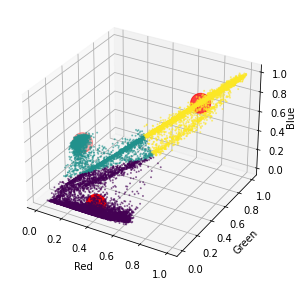

In [13]:
# Run your K-means function on the data
centroids, clusters, error = my_kmeans(im, 3)
print('centroids cordinates:')
print(centroids)
      
# Print the errors:
print('\nerror: ',error[-1])

# Plot the results
scatter_plot(im, clusters, centroids)


### TO DO (A.3) 
Plot the value of the error versus the number of iterations

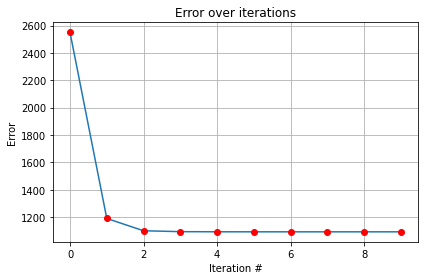

In [14]:
# Sugestion: use the function error_plot()
error_plot(error)

### TO DO (A.4)
Now use the k-means function provided in sklearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Go to the documentation page for further details

In [18]:
# Define the K-means model
kmeans = KMeans(n_clusters=3, random_state=0, init='random', n_init=10)

# Fit the model to the data
kmeans.fit(im)

# Get the cluster centers
k_centroids = kmeans.cluster_centers_
k_err = kmeans.inertia_
print('centroid cordinates:')
print(k_centroids)
print('\nerror:', k_err)



centroid cordinates:
[[0.39262661 0.05386229 0.0671155 ]
 [0.07849431 0.39469093 0.3431354 ]
 [0.77990258 0.77032897 0.76764366]]

error: 1092.8769445106204


Perform the same plot as above but with the output of the k-means function provided in sklearn.

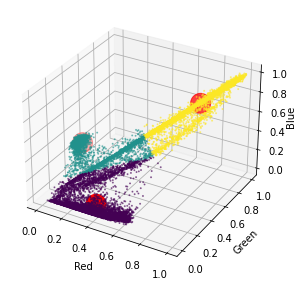

In [19]:

scatter_plot(im, kmeans.fit_predict(im), k_centroids)

### TO DO (A.Q1) [Answare the following] 

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, *i.e.*, do the two plots match?

**ANSWER A.Q1:** The two plots are essentially identical; both algorithms have clustered the image in the same way. This is also noticeable by observing the cluster centers, which coincide for both

### TO DO (A.5)

Now display the segmented image based on the two clusters found above with the k-means functions by sklearn.

(172, 256, 3)


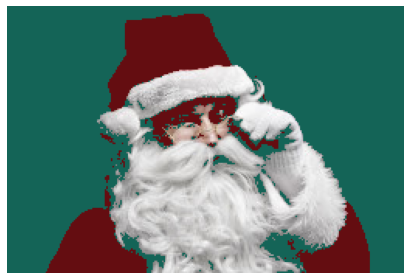

In [20]:
# Extarct the color values of the centers
for i in range(3):
    im[i == kmeans.fit_predict(im)] = kmeans.cluster_centers_[i]
# Reshape the data to the original image shape
im = im.reshape(172,256,3)
print(im.shape)
# Plot the recolored image
img_plot(im)


Now display the segmented image based on the two clusters found above with the k-means functions implemented by yourselves.

(172, 256, 3)


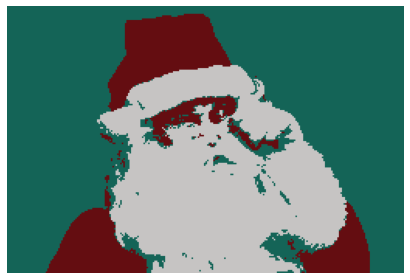

In [21]:
# Extarct the color values of the centers
im = im.reshape(im.shape[0]*im.shape[1],3)
for i in range(3):
    im[i == clusters] = centroids[i]
# Reshape the data to the original image shape
im = im.reshape(172,256,3)
print(im.shape)
# Plot the recolored image
img_plot(im)




### TO DO (A.Q2) [Answare the following]

What do you observe? Do you think clustering is useful for image segmenation? And for image compression? Comment your answer.

**ANSWER A.Q2:** If properly defined, clustering can greatly simplify an image without 'removing too much information' from the image itself. In this way, it's possible to analyze images by preprocessing them to clearly define figures and backgrounds. 

### TO DO (A.6)

Now load the landscape image (optional: try also with the reindeer image) and segment it using kmeans with k varying from 2 to 15 clusters. You can use the sklearn implementation.

Then plot the resulting data points in the 3-dimensional space, each point must be colored based on the cluster membership.


K-means clustering with different values of K (2-15):


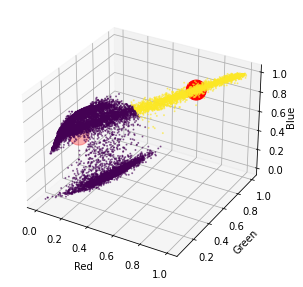


coordinate centri:
[[0.1175967  0.33529436 0.50388649]
 [0.73803837 0.79667913 0.87808285]]


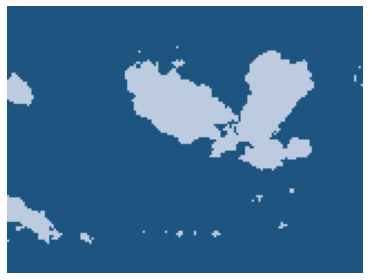

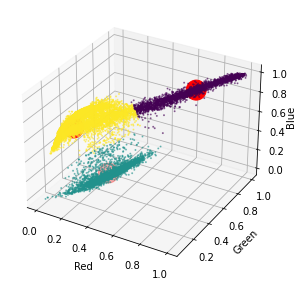


coordinate centri:
[[0.737668   0.79631044 0.87771695]
 [0.30991623 0.38704395 0.14724397]
 [0.08159491 0.32557574 0.57041941]]


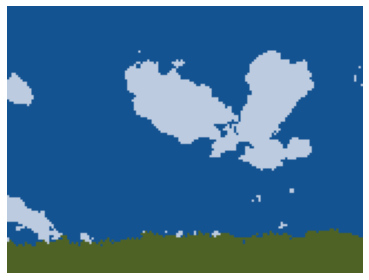

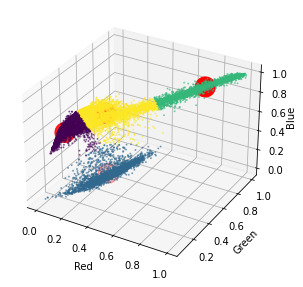


coordinate centri:
[[0.03933067 0.28660187 0.53503455]
 [0.30928592 0.38657769 0.14594055]
 [0.78545187 0.83342288 0.90242441]
 [0.24312388 0.46322642 0.68674349]]


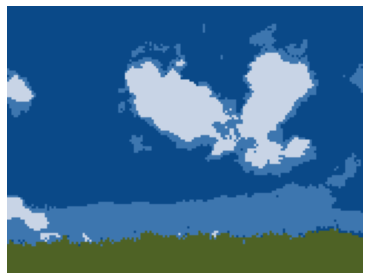

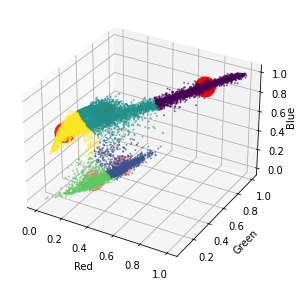


coordinate centri:
[[0.78449213 0.83265306 0.9019091 ]
 [0.37761894 0.45435738 0.20101813]
 [0.24030262 0.46206282 0.68724671]
 [0.23870174 0.3165008  0.09080347]
 [0.03922621 0.28622942 0.53446291]]


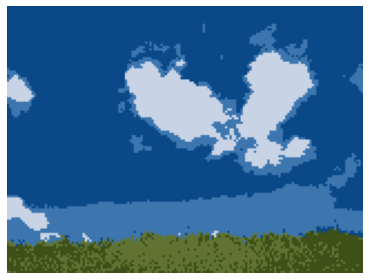

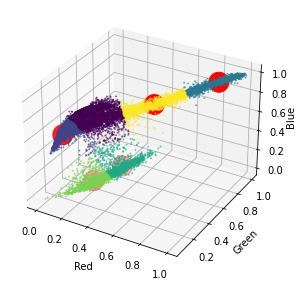


coordinate centri:
[[0.15817702 0.41230963 0.66137472]
 [0.0313013  0.27354316 0.51882349]
 [0.85575753 0.88867714 0.93871992]
 [0.3776811  0.45440474 0.201101  ]
 [0.23870174 0.3165008  0.09080347]
 [0.51933447 0.62723173 0.76565228]]


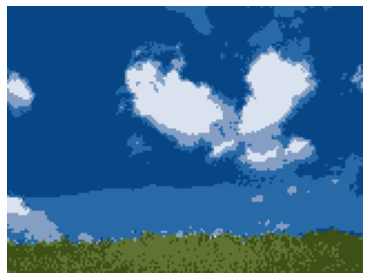

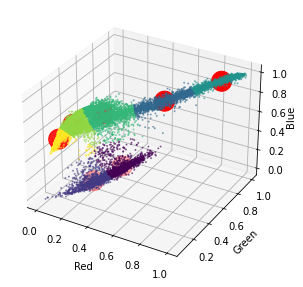


coordinate centri:
[[0.37683109 0.45361529 0.19974208]
 [0.23785591 0.31556796 0.0902434 ]
 [0.57356284 0.66781111 0.7923901 ]
 [0.8700027  0.89977015 0.94616639]
 [0.22661238 0.45442392 0.68418409]
 [0.07090182 0.33552039 0.59648732]
 [0.01505948 0.24768208 0.4849253 ]]


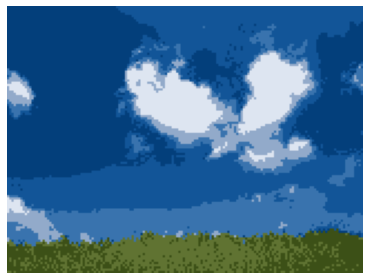

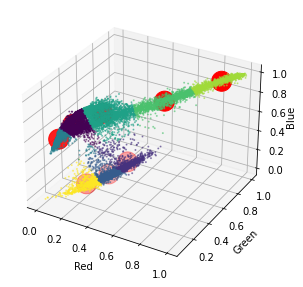


coordinate centri:
[[0.07085691 0.33544047 0.59639734]
 [0.4033245  0.47847436 0.23478302]
 [0.31055894 0.39034257 0.13518519]
 [0.01505653 0.24767653 0.4849123 ]
 [0.22586448 0.45430499 0.6850711 ]
 [0.57356284 0.66781111 0.7923901 ]
 [0.8700027  0.89977015 0.94616639]
 [0.20441176 0.28079616 0.07030812]]


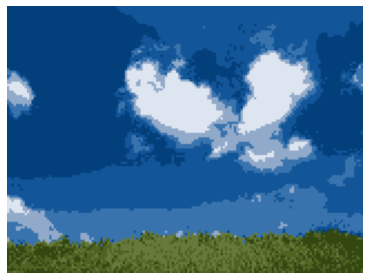

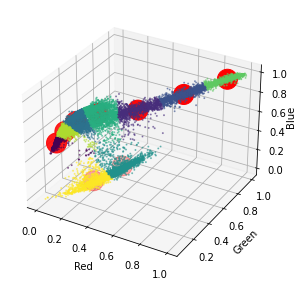


coordinate centri:
[[0.0106407  0.22809767 0.45787127]
 [0.43259976 0.56260546 0.72084095]
 [0.67340236 0.74523457 0.84457087]
 [0.08212267 0.35366222 0.61842277]
 [0.37676478 0.453634   0.19947634]
 [0.2007012  0.44274414 0.68285036]
 [0.89987725 0.9234325  0.96149821]
 [0.03623577 0.29044879 0.5417031 ]
 [0.23831338 0.31592763 0.0898869 ]]


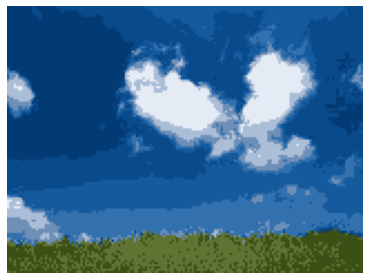

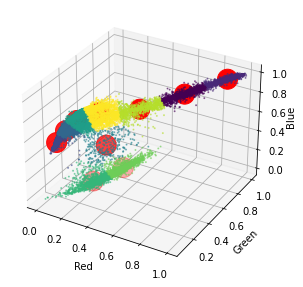


coordinate centri:
[[0.67792172 0.74887177 0.84691488]
 [0.90055071 0.92392742 0.96180126]
 [0.01018786 0.23008573 0.46120492]
 [0.03877022 0.29401102 0.54764073]
 [0.28595006 0.40238398 0.4183947 ]
 [0.08521918 0.35916823 0.62527663]
 [0.23698266 0.31433155 0.08788203]
 [0.38271959 0.4581253  0.18145066]
 [0.44239917 0.57014011 0.72847902]
 [0.20442482 0.4460626  0.68870174]]


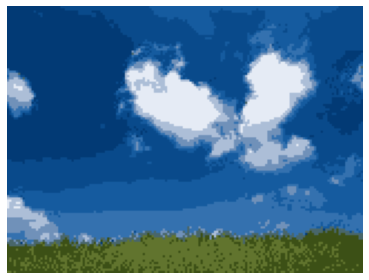

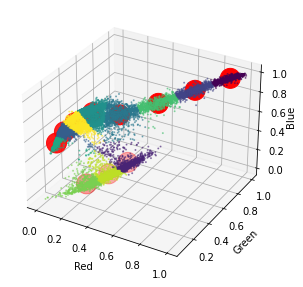


coordinate centri:
[[0.914831   0.93494304 0.96833613]
 [0.40411062 0.47914394 0.22954507]
 [0.73216341 0.79196032 0.87654546]
 [0.03390101 0.2884055  0.5397745 ]
 [0.33033881 0.49656994 0.67974323]
 [0.16500358 0.42967639 0.68703346]
 [0.01057304 0.22805275 0.45792503]
 [0.54102268 0.64222895 0.77533641]
 [0.20453111 0.28083718 0.06985463]
 [0.30999192 0.38970541 0.13624349]
 [0.07953969 0.34710534 0.60948643]]


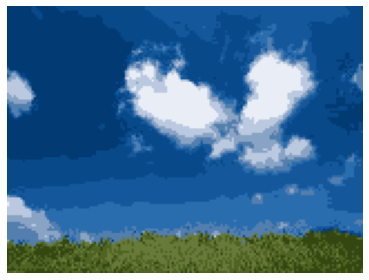

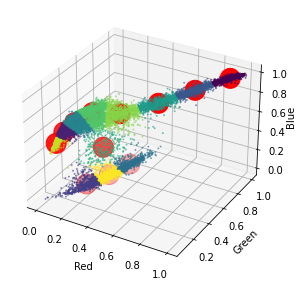


coordinate centri:
[[0.914831   0.93494304 0.96833613]
 [0.03146725 0.28573914 0.5371602 ]
 [0.20470263 0.28077997 0.06917257]
 [0.73239985 0.79213341 0.87666291]
 [0.41512061 0.48827065 0.21035055]
 [0.07747683 0.34552872 0.60920222]
 [0.54210972 0.6430889  0.77591451]
 [0.2717937  0.38860151 0.40082399]
 [0.16453163 0.42928337 0.68706323]
 [0.33122033 0.49990214 0.68880432]
 [0.00948923 0.22556027 0.45554791]
 [0.31271652 0.39141984 0.12888758]]


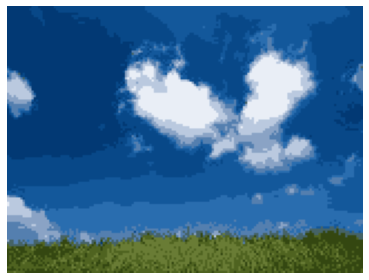

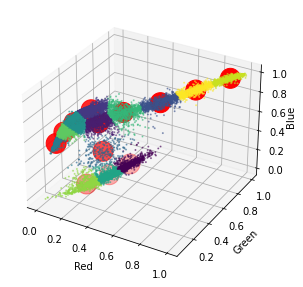


coordinate centri:
[[0.41564246 0.48872823 0.21043378]
 [0.22375468 0.410905   0.61770453]
 [0.14970223 0.43631335 0.70602594]
 [0.55186891 0.65043167 0.78075461]
 [0.27414423 0.38055833 0.36590229]
 [0.00952563 0.22556343 0.45548657]
 [0.0739114  0.34466165 0.60993164]
 [0.31359357 0.39222882 0.12689333]
 [0.3504666  0.51404005 0.69980078]
 [0.03156872 0.28574687 0.53708385]
 [0.20505059 0.28089122 0.0680793 ]
 [0.91527535 0.93526973 0.96854489]
 [0.73565171 0.79467204 0.87844097]]


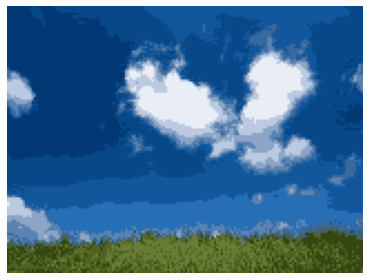

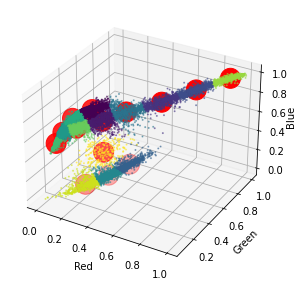


coordinate centri:
[[0.15529116 0.43949404 0.7076978 ]
 [0.24219292 0.42708348 0.6299258 ]
 [0.55875592 0.65564051 0.78445935]
 [0.73790281 0.79643405 0.87959079]
 [0.41401243 0.48722568 0.20811945]
 [0.36758233 0.52368712 0.70452652]
 [0.3093599  0.38845534 0.12272388]
 [0.02572549 0.28269479 0.53549371]
 [0.0543591  0.35607681 0.63774712]
 [0.00951118 0.22541781 0.45537854]
 [0.09961126 0.33014932 0.57224107]
 [0.91565802 0.93554086 0.96863499]
 [0.20068686 0.2761477  0.06703064]
 [0.27856048 0.38063423 0.35721778]]


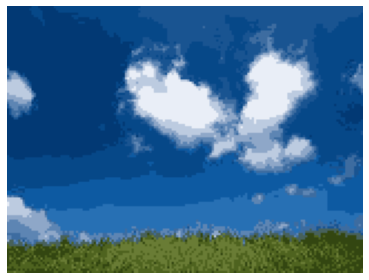

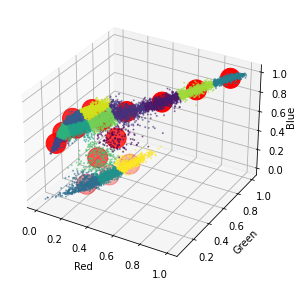


coordinate centri:
[[0.33543092 0.44711962 0.47666819]
 [0.56034568 0.65681314 0.78522232]
 [0.36907122 0.52554808 0.70816873]
 [0.00951118 0.22541781 0.45537854]
 [0.0543591  0.35607681 0.63774712]
 [0.20484495 0.280534   0.06584342]
 [0.91565802 0.93554086 0.96863499]
 [0.31357276 0.39261094 0.12360372]
 [0.0999318  0.33035143 0.5722137 ]
 [0.02573786 0.28269903 0.53549744]
 [0.25037396 0.35156661 0.31123913]
 [0.24016881 0.42824288 0.63793537]
 [0.7384902  0.79687255 0.87982843]
 [0.15444698 0.4391384  0.70782444]
 [0.41452714 0.48757989 0.20892103]]


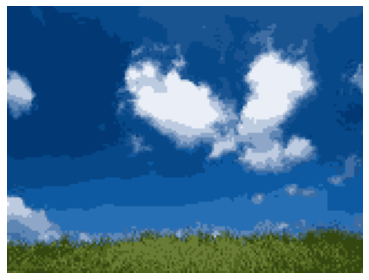

In [22]:
# Reshape the data to a matrix of total_num_pixels x 3
im = (plt.imread('/Users/giacomo/Desktop/POD/ML_POD/lab3-2/data/landscape.jpg'))
x_shape = im.shape[0]
y_shape = im.shape[1]
# Print the shape of the data and the min and max values of the pixels
# im = im/255
# im = im.reshape(x_shape*y_shape,3) #172x256


# Cycle over different values of K and plot the results for each value
print('\nK-means clustering with different values of K (2-15):')
inertia = list()
for k in range(2,16):

    im_copy = im
    im_copy = im_copy/255
    im_copy = im_copy.reshape(x_shape*y_shape,3) #172x256
    
    # Define the K-means model
    cent, clust, er = my_kmeans(im_copy, k)

    # Fit the model to the data
    scatter = scatter_plot(im_copy, clust, cent)

    # Get the cluster centers
    print('\ncoordinate centri:')
    print(cent)
    

    # Extarct the color values of the centers
    for i in range(k):
        im_copy[clust == i] = cent[i]
        
   

    # Update the inertia
    inertia.append(er[-1])
    
    
    im_copy = im_copy.reshape(x_shape,y_shape,3)
    # Plot the recolored image
    plot = img_plot(im_copy)
   

    
    


K-means clustering with different values of K (2-15):



coordinate centri:
[[0.11763393 0.33532013 0.50391298]
 [0.73826578 0.79685963 0.87819602]]


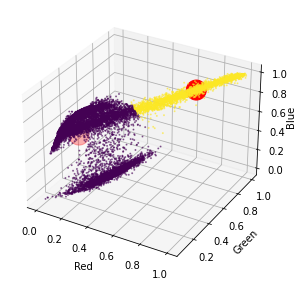

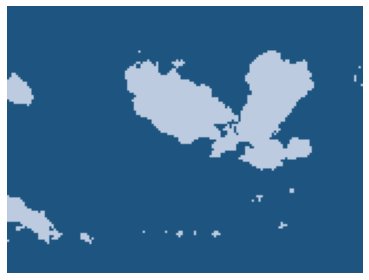


coordinate centri:
[[0.737668   0.79631044 0.87771695]
 [0.08159491 0.32557574 0.57041941]
 [0.30991623 0.38704395 0.14724397]]


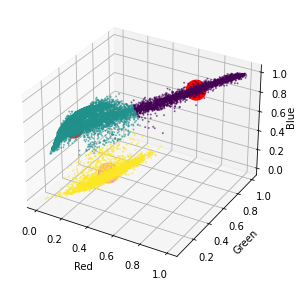

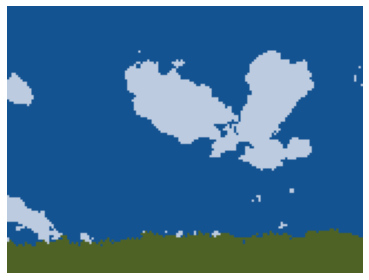


coordinate centri:
[[0.78545187 0.83342288 0.90242441]
 [0.03928952 0.28653387 0.53495848]
 [0.30928592 0.38657769 0.14594055]
 [0.24286316 0.46308901 0.68667385]]


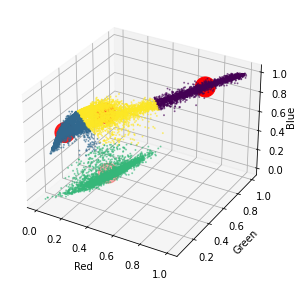

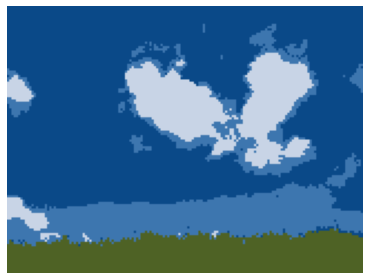


coordinate centri:
[[0.15985768 0.41308981 0.66123313]
 [0.52089604 0.62822918 0.76605106]
 [0.3096562  0.38686008 0.14620369]
 [0.03128053 0.27381312 0.51930463]
 [0.85624912 0.88907697 0.93898058]]


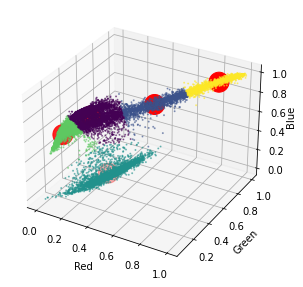

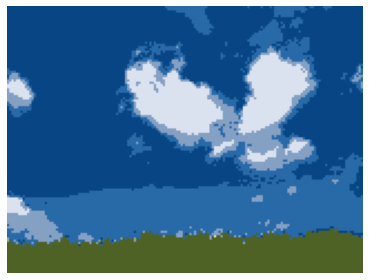


coordinate centri:
[[0.22490809 0.45328351 0.68296169]
 [0.57136357 0.6661343  0.7912345 ]
 [0.30986343 0.38699168 0.14586099]
 [0.0140307  0.24578116 0.48249466]
 [0.06916822 0.33326015 0.5937359 ]
 [0.86942174 0.89931059 0.94586803]]


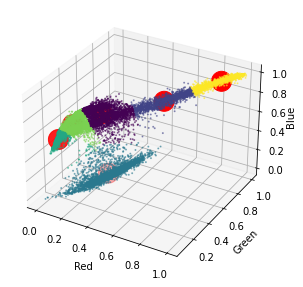

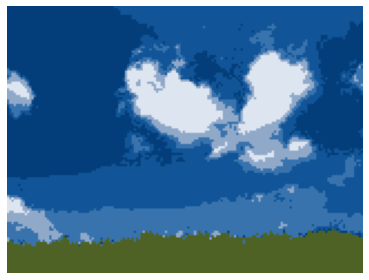


coordinate centri:
[[0.01462367 0.2466981  0.48357273]
 [0.87027945 0.89999743 0.94634604]
 [0.22642416 0.45426945 0.68407687]
 [0.37660793 0.45342626 0.19957628]
 [0.23764896 0.31532703 0.09006947]
 [0.57404251 0.6681912  0.79263192]
 [0.06996552 0.33442772 0.59523626]]


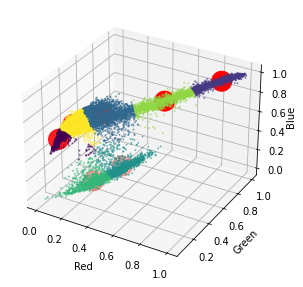

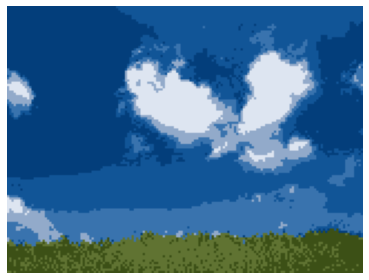


coordinate centri:
[[0.17174485 0.42828777 0.67868808]
 [0.89541136 0.91993905 0.95935066]
 [0.23877303 0.31653106 0.0906325 ]
 [0.01259741 0.24197195 0.47723046]
 [0.39239181 0.5365466  0.70503239]
 [0.06195865 0.32366156 0.58279853]
 [0.65459703 0.73035847 0.83462398]
 [0.37718737 0.45407855 0.20075233]]


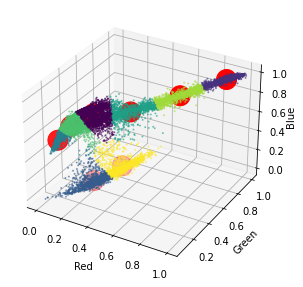

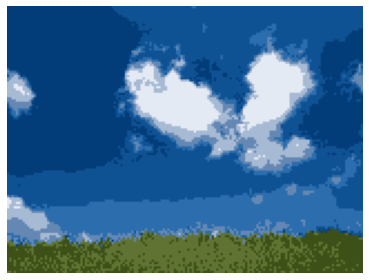


coordinate centri:
[[0.12560744 0.4039366  0.66971043]
 [0.71214239 0.7758871  0.86593392]
 [0.37622859 0.45285516 0.19711058]
 [0.01181356 0.23891208 0.47304849]
 [0.90820392 0.92972549 0.96521133]
 [0.51278132 0.62078572 0.76063007]
 [0.05673915 0.31474683 0.5713586 ]
 [0.23687426 0.31456674 0.08959473]
 [0.28591121 0.47627477 0.67802169]]


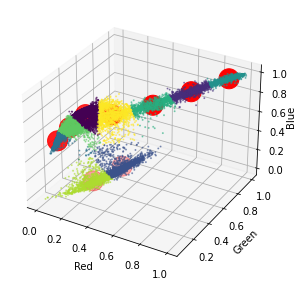

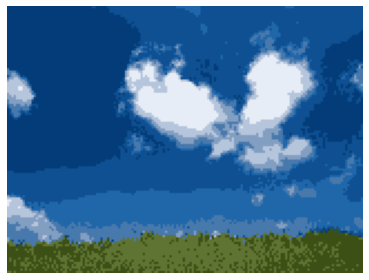


coordinate centri:
[[0.37585384 0.45274917 0.19760284]
 [0.16411929 0.42928568 0.6868812 ]
 [0.91474786 0.93486689 0.96829537]
 [0.03209905 0.28599123 0.5366103 ]
 [0.7318236  0.7916988  0.87636542]
 [0.23714748 0.31473875 0.08914755]
 [0.32969634 0.49577998 0.67865695]
 [0.01043429 0.22603187 0.45496658]
 [0.07870513 0.3456985  0.60780596]
 [0.54037968 0.64179327 0.7750594 ]]


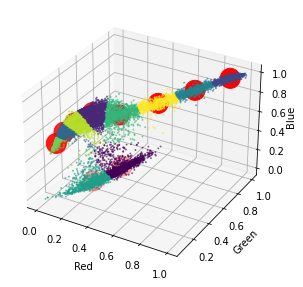

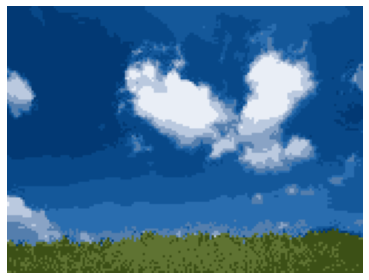


coordinate centri:
[[0.40411062 0.47914394 0.22954507]
 [0.07985347 0.34728435 0.60952348]
 [0.7318236  0.7916988  0.87636542]
 [0.01056984 0.22806324 0.45793836]
 [0.20453111 0.28083718 0.06985463]
 [0.54067605 0.64195838 0.77511849]
 [0.91474786 0.93486689 0.96829537]
 [0.30999192 0.38970541 0.13624349]
 [0.16494132 0.42967296 0.68710775]
 [0.3301604  0.49647199 0.67973623]
 [0.03387326 0.2885273  0.54002803]]


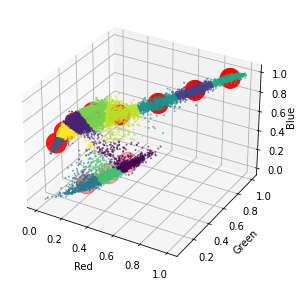

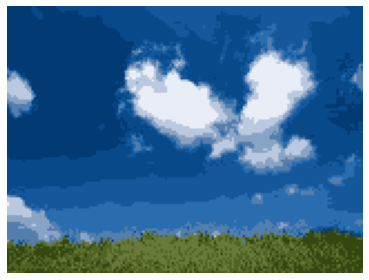


coordinate centri:
[[0.01003632 0.22586229 0.4552296 ]
 [0.914831   0.93494304 0.96833613]
 [0.30639098 0.38608654 0.13431741]
 [0.54300556 0.6437372  0.77625598]
 [0.33519474 0.50436877 0.69415587]
 [0.07198014 0.3431699  0.60898091]
 [0.73239985 0.79213341 0.87666291]
 [0.21876153 0.39740694 0.58415627]
 [0.40788221 0.48134203 0.22082387]
 [0.15026369 0.43455939 0.70273158]
 [0.20122477 0.2771951  0.06796619]
 [0.03096409 0.28502032 0.53602755]]


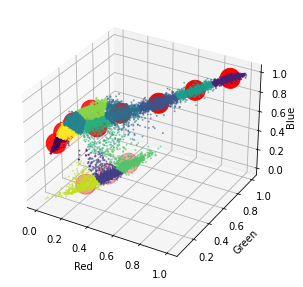

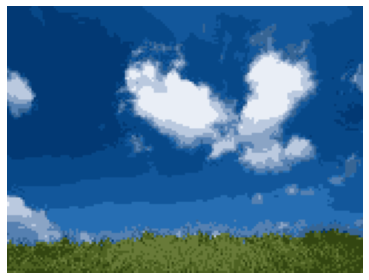


coordinate centri:
[[0.14562062 0.4255912  0.69185166]
 [0.00971986 0.2276346  0.4584396 ]
 [0.75996916 0.81383565 0.89078542]
 [0.41333123 0.48657415 0.20903643]
 [0.20088308 0.27654902 0.06785766]
 [0.43668526 0.56493974 0.72408707]
 [0.07918737 0.34589723 0.60877673]
 [0.60172139 0.68873689 0.80737004]
 [0.92008018 0.93898547 0.97077479]
 [0.27254902 0.38721569 0.39267451]
 [0.30899643 0.38787984 0.12549406]
 [0.03307505 0.28818699 0.54056428]
 [0.27577043 0.46787278 0.67542631]]


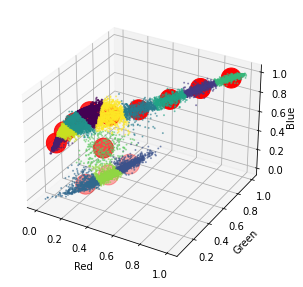

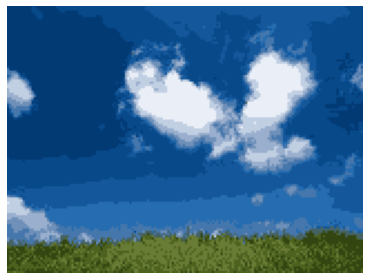


coordinate centri:
[[0.20505059 0.28089122 0.0680793 ]
 [0.07751852 0.32174192 0.57292289]
 [0.91600204 0.93581409 0.96878628]
 [0.36935726 0.5240121  0.70340193]
 [0.06385639 0.36605579 0.64611544]
 [0.00910797 0.22183226 0.45000037]
 [0.56148125 0.65785614 0.78626931]
 [0.16090259 0.44330022 0.71067655]
 [0.27349673 0.38062092 0.36802288]
 [0.4159176  0.48895131 0.21073474]
 [0.73971019 0.79784486 0.88045858]
 [0.23404973 0.42005915 0.62521634]
 [0.02079729 0.2752823  0.52569172]
 [0.3138091  0.39245944 0.12701503]]


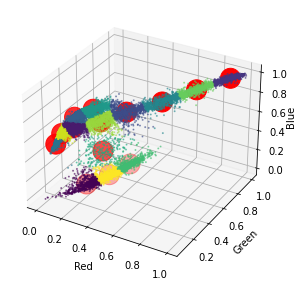

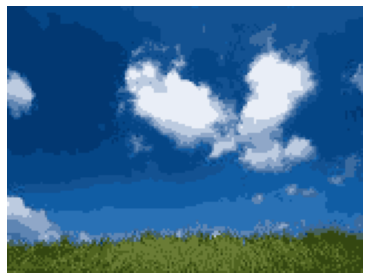


coordinate centri:
[[0.14945279 0.43577571 0.7056887 ]
 [0.92141128 0.93996611 0.97137497]
 [0.3093599  0.38845534 0.12272388]
 [0.02350647 0.27952841 0.53146816]
 [0.615345   0.69979523 0.81496029]
 [0.31196343 0.49351263 0.69172408]
 [0.76524679 0.81800766 0.89374014]
 [0.41401243 0.48722568 0.20811945]
 [0.0093021  0.22353488 0.45258977]
 [0.05283473 0.35359975 0.63529213]
 [0.09263608 0.32606003 0.56931312]
 [0.20093623 0.27631749 0.06644291]
 [0.27917373 0.38097313 0.3572662 ]
 [0.46957204 0.5876283  0.73783461]
 [0.21420623 0.40386215 0.61268298]]


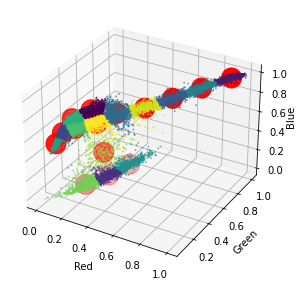

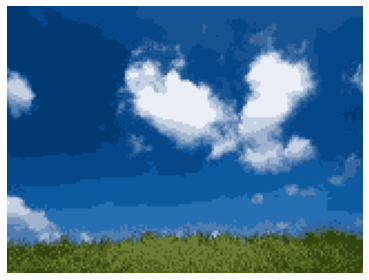

In [23]:
# Reshape the data to a matrix of total_num_pixels x 3
im = (plt.imread('/Users/giacomo/Desktop/POD/ML_POD/lab3-2/data/landscape.jpg'))
x_shape = im.shape[0]
y_shape = im.shape[1]
# Print the shape of the data and the min and max values of the pixels


# Cycle over different values of K and plot the results for each value
print('\nK-means clustering with different values of K (2-15):')
inertia = list()
for k in range(2,16):

    im_copy = im
    im_copy = im_copy/255
    im_copy = im_copy.reshape(x_shape*y_shape,3) #172x256
    
    # Define the K-means model
    kmeans = KMeans(n_clusters=k)

    # Fit the model to the data
    kmeans.fit(im_copy)


    # Get the cluster centers
    print('\ncoordinate centri:')
    clust = kmeans.fit_predict(im_copy)
    cent = kmeans.cluster_centers_
    print(cent)
    scatter_plot(im_copy,clust, cent)

    # Extarct the color values of the centers
    for i in range(k):
        im_copy[clust == i] = cent[i]
        
    # Update the inertia
    inertia.append(kmeans.inertia_)
    
    
    im_copy = im_copy.reshape(x_shape,y_shape,3)
    # Plot the recolored image
    plot = img_plot(im_copy)
   

    
    

### TO DO (A.7)

Plot for different values of k (e.g. k between 2 and 15) the respective error of the kmeans algorithm 

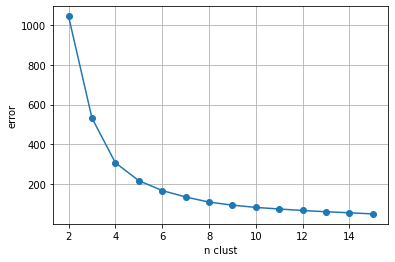

In [24]:
k = np.arange(2,16,1)
plot = plt.figure()
ax = plot.add_subplot(1,1,1)
ax.plot(k, inertia, marker = 'o')
ax.set_xlabel('n clust')
ax.set_ylabel('error')
ax.grid()



### TO DO (AQ.3) [Answare the following]

Compare the results with different values of k, what do you observe? 

Analyze also the error, which one do you think is the optimal value of k?

Is there a single, clear answer?

**ANSWER A.Q3:** As the number of clusters increases, the error progressively decreases. However, it's important to consider that the complexity of the image increases as well. Defining an optimal cluster value solely based on error analysis can lead to a suboptimal choice. For this reason, in the given example, considering 4 to 6 clusters for the image makes it easier to analyze while simultaneously not removing excessive information.

---

## B) Linkage-based clustering

The second part of the assignment concern instead linkage-based clustering. We will use the AgglomerativeClustering module of sklearn. 

### TO DO (B.0)

Load the sample dataset located at `data/moon_data.npz`

In [25]:
# Load sample data
data = np.load('/Users/giacomo/Desktop/POD/ML_POD/lab3-2/data/moon_data.npz') # ADD YOUR CODE HERE (use np.load())

# Extract data
x = data['X']
labels_true = data['labels_true']



### TO DO (B.1)

Now exploit the AgglomerativeClustering algorithm from sklearn on the provided sample data points. Use the "single" linkage type that correspond to the minimum distance criteria seen in the lectures and 2 clusters. Notice that the "single" option has been introduced recently in sklearn, if you get an error ensure you have a recent version of the library. Plot the resulting clustering.

In [26]:
# Compute Agglomerative Clustering
# Define the Agglomerative Clustering model
clustering = AgglomerativeClustering(n_clusters=2, linkage='single')

# Fit the model to the data
clustering.fit(x)

# Compute the number of clusters in labels, ignoring noise if present.
unique = np.unique(labels_true)
print('numero di labels differenti:', len(unique))

# Print the results
clusters = clustering.fit_predict(x)
print(clusters)


numero di labels differenti: 2
[1 0 1 ... 1 0 1]


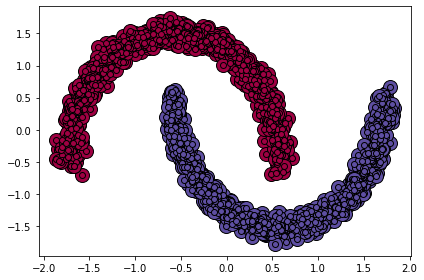

In [27]:
# Plot result 
# Sugestion: use the function cluster_plot()
cluster_plot(clusters,x)

### TO DO (B.2)

Now try the KMeans with two clusters on the same dataset we used for the AgglomerativeClustering algorithm.

[[-0.74529865  0.79045186]
 [ 0.73739097 -0.78206511]]


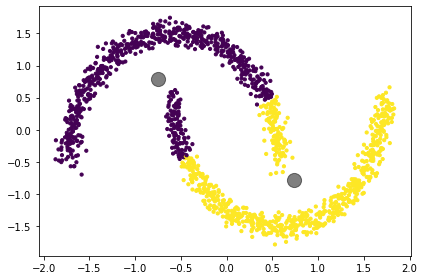

In [28]:
# Define the K-means model
clustering = KMeans(n_clusters=2, random_state=18)

# Fit the model to the data
clustering.fit(x)

# Get the cluster centers
centers = clustering.cluster_centers_


# Extarct the color values of the centers
print(centers)

# Plot the results
# Sugestion: use the function scatter_plot_2d()
scatter_plot_2d(x, clustering.labels_, centers)

### TO DO (B.Q1) [Answare the following]

Compare the results of K-means and Agglomerative Clustering and explain what you observe and why?

**ANSWER B.Q1:** Clustering through linkage proves to be more effective in reflecting the data distribution in space compared to K-means clustering. This difference arises from the distinct algorithmic approach and the unique data structure. The initialization of the linkage algorithm allows clusters to expand progressively, neglecting the data's geometric structure in space. On the other hand, the K-means algorithm, by predefining centers in the data space, may fail to capture complex geometries due to this a priori initialization.

---